In [1]:
import sys
import pickle
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("../..")
import gradient_analyze as ga
import hp_file

In [2]:
filename = './results.pickle'

with open(filename, "rb") as file:
    results = pickle.load(file)

In [3]:
g_ex = np.array([-0.3376,  0.1305,  0.2561, -0.3416,  0.    ])

In [4]:
f = lambda x, y: np.sum((np.array(x, dtype="float64") - np.array(y, dtype="float64")) ** 2)

ga.calculate_new_quantity(['g_fd', 'g_ex'], 'g_fd_err', f, results, hp_file)
ga.calculate_new_quantity(['g_ps', 'g_ex'], 'g_ps_err', f, results, hp_file)

In [5]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ https://stackoverflow.com/questions/2827393/angles-between-two-n-dimensional-vectors-in-python/13849249#13849249
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

ga.calculate_new_quantity(['g_fd', 'g_ex'], 'g_fd_ang', angle_between, results, hp_file)
ga.calculate_new_quantity(['g_ps', 'g_ex'], 'g_ps_ang', angle_between, results, hp_file)
results_processed_ang = ga.access_quantities(['g_fd_ang', 'g_ps_ang'], results, hp_file)

In [6]:
results_processed = ga.avg_quantities(['g_fd_err', 'g_ps_err'], results, hp_file)

In [7]:
results_processed_accessed = ga.access_quantities(['g_fd_err', 'g_ps_err'], results, hp_file)

In [8]:
cols = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [9]:
def delta(h, N):
    f_big = np.expand_dims(f, axis=0)
    h_big = np.expand_dims(h, axis=1)
    t1 = sigma0 / (2 * N * h_big ** 2)
    t2 = f_big ** 2 * h_big ** 4 / 36
    return t1 + t2

def h_fd_opt(N):
    
    numerator = 9 * len(f) * sigma0
    denominator = N * np.sum(f ** 2)
    
    return np.power(numerator / denominator, 1 / 6)

def delta_ps(h, N):
    return sigma0 / (2 * N * np.sin(h) ** 2)

In [10]:
g = np.array([-0.3376,  0.1305,  0.2561, -0.3416,  0.    ])
f = -g

sigma0 = 0.37435063960000015

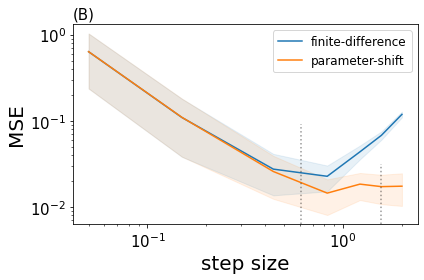

In [11]:
x, y_fd = ga.make_numpy(results_processed, "h", "g_fd_err")
x, y_ps = ga.make_numpy(results_processed, "h", "g_ps_err")

stds_fd = []
stds_ps = []

for h in x:
    errors = list(ga.calculate_slice({"h": h}, results_processed_accessed).values())[0]
    errors_fd = errors["g_fd_err"]
    errors_ps = errors["g_ps_err"]
    
    stds_fd.append(np.std(errors_fd))
    stds_ps.append(np.std(errors_ps))

stds_fd = np.array(stds_fd)
stds_ps = np.array(stds_ps)


plt.fill_between(x, y_fd - stds_fd, y_fd + stds_fd, color=cols[0], alpha=0.1)
plt.fill_between(x, y_ps - stds_ps, y_ps + stds_ps, color=cols[1], alpha=0.1)
plt.plot(x, y_fd, label="finite-difference", c=cols[0])
plt.plot(x, y_ps, label="parameter-shift", c=cols[1])
plt.axvline(np.pi / 2, c="black", alpha=0.4, linestyle=":", ymax=0.3)
plt.axvline(0.613, c="black", alpha=0.4, linestyle=":", ymax=0.5)
plt.xlabel('step size', fontsize=20)
plt.ylabel('MSE', fontsize=20)
plt.xscale("log")
plt.tick_params(labelsize=15)
plt.legend(fontsize=12)

plt.title("(B)", loc="left", fontsize=15)
plt.yscale("log")
plt.tight_layout()
plt.savefig("fd-vs-ps-hw.pdf")

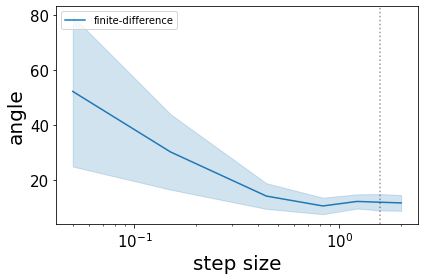

In [13]:
angs_fd = []
angs_ps = []
angs_mean_fd = []
angs_mean_ps = []

for h in x:
    angles = list(ga.calculate_slice({"h": h}, results_processed_ang).values())[0]
    angles_fd = angles["g_fd_ang"] * 360 / (2 * np.pi)
    angles_ps = angles["g_ps_ang"] * 360 / (2 * np.pi)
    angs_fd.append(np.std(angles_fd))
    angs_ps.append(np.std(angles_ps))
    angs_mean_fd.append(np.mean(angles_fd))
    angs_mean_ps.append(np.mean(angles_ps))

angs_fd = np.array(angs_fd)
angs_ps = np.array(angs_ps)
angs_mean_fd = np.array(angs_mean_fd)
angs_mean_ps = np.array(angs_mean_ps)


plt.fill_between(x, angs_mean_fd - angs_fd, angs_mean_fd + angs_fd, color=cols[0], alpha=0.2)
plt.plot(x, angs_mean_fd , label="finite-difference", c=cols[0])
plt.axvline(np.pi / 2, c="black", alpha=0.4, linestyle=":")
plt.xlabel('step size', fontsize=20)
plt.ylabel('angle', fontsize=20)
plt.xscale("log")
plt.tick_params(labelsize=15)
plt.legend()
plt.tight_layout()